# 02 - Failing fits

This tutorial shows examples of fits that fail and how to identify and fix the issue or avoid it in the first place.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data and model

Let's use the same data and model as in the previous notebooks.


In [2]:
df = pd.DataFrame({
    "x": [9, 14, 21, 28, 42, 57, 63, 70, 79],
    "y": [8.93, 10.80, 18.59, 22.33, 39.35, 56.11, 61.73, 64.62, 67.08]
})

In [3]:
def model(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 - b3 * x))

## A failing fit

Fits and warnings and errors can sometimes change depending on your system and library versions. For me, the following fit gives two warnings:

1. RuntimeWarning: overflow encountered in exp
2. OptimizeWarning: Covariance of the parameters could not be estimated

In [4]:
import scipy.optimize

In [5]:
popt, pcov = scipy.optimize.curve_fit(f=model, xdata=df["x"], ydata=df["y"])

/Users/cdeil/anaconda3/envs/py-model-fit/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6v/0_6nt0pj07x9xjhd8qzkyy700000gn/T/ipykernel_26856/1918929932.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(f=model, xdata=df["x"], ydata=df["y"])


In [6]:
popt

array([  38.83777778, -986.43411354,  111.60437184])

In [7]:
pcov

array([[inf, inf, inf],
       [inf, inf, inf],
       [inf, inf, inf]])

In this case our model and cost function only has one `exp` call `np.exp(b2 - b3 *x)` so it's clear that the overflow happened because `b2 - b3 * x` was too large.
Also the `pcov` being `inf` makes sense if the optimiser warns that covariance cound not be estimated.

But some `popt` was computed. Is it valid? 

The [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) docstring says this:
> Raises: RuntimeError: if the least-squares minimization fails. 

Well, in this case `popt` is not valid. The fit failed and the function didn't raise a `RuntimeError`.

**Learning 1: if you get any warnings/errors, don't trust the fit. Fix them.**


## What's the problem?

In this case, and actually it's probably the most common issue of failing fits, the problem is that the initial guess for the parameters `p0` was bad.

As stated in the [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) docstring description of `p0`:
> Initial guess for the parameters (length N). If None, then the initial values will all be 1

So effectively we were doing this:

In [8]:
p0=[1, 1, 1]
popt, pcov, infodict, msg, ier = scipy.optimize.curve_fit(f=model, xdata=df["x"], ydata=df["y"], p0=p0, full_output=True)

/Users/cdeil/anaconda3/envs/py-model-fit/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6v/0_6nt0pj07x9xjhd8qzkyy700000gn/T/ipykernel_26856/3188724692.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov, infodict, msg, ier = scipy.optimize.curve_fit(f=model, xdata=df["x"], ydata=df["y"], p0=p0, full_output=True)


In [9]:
infodict

{'fvec': array([ 29.90777778,  28.03777778,  20.24777778,  16.50777778,
         -0.51222222, -17.27222222, -22.89222222, -25.78222222,
        -28.24222222]),
 'nfev': 21,
 'fjac': array([[-2.99999999,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
          0.33333333,  0.33333333,  0.33333333,  0.33333333],
        [ 0.        , -0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ]]),
 'ipvt': array([1, 2, 3], dtype=int32),
 'qtf': array([2.08951083e-07, 2.05608333e+01, 1.27708333e+01])}

In [10]:
msg

'The relative error between two consecutive iterates is at most 0.000000'

In [11]:
ier

2

That's pretty cryptic and to me at least not helpful. There's no clear fit success/failure flag or message.

**Learning 2: scipy.optimize.curve_fit doesn't help you much to debug failing fits.**

## Tracing the function calls

One thing you can do to undertand what's going on is to trace the optimisation to see the evolution in the parameter estimation.

This is something often done in Bayesian frameworks like [pymc](https://www.pymc.io/welcome.html) or MCMC samplers like [emcee](https://emcee.readthedocs.io/en/stable/) or in neural net fitting with [pytorch](https://pytorch.org/) or [tensorflow](https://www.tensorflow.org/).
But also some nonlinear optimisation packages like [estimagic](https://estimagic.org/) have this built in.

I didn't find a built-in option to do this with scipy or iminuit, and for lmfit I only found a `trace=True` option for [lmfit.conf_interval](https://lmfit.github.io/lmfit-py/confidence.html#confidence-interval-functions) and not the main fit function.

Here we just add print statements printing dicts in [JSONL](https://jsonlines.org/) format, but you could write it to a text or SQLite file or in-memory list if you want to capture it as part of the fit results.


In [12]:
def model(x, b1, b2, b3):
    print({"b1": b1, "b2": b2, "b3": b3})
    return b1 / (1 + np.exp(b2 - b3 * x))

In [13]:
p0=[1, 1, 1]
popt, pcov = scipy.optimize.curve_fit(f=model, xdata=df["x"], ydata=df["y"], p0=p0)

{'b1': 1, 'b2': 1, 'b3': 1}
{'b1': 1.0000000149011612, 'b2': 1.0, 'b3': 1.0}
{'b1': 1.0, 'b2': 1.0000000149011612, 'b3': 1.0}
{'b1': 1.0, 'b2': 1.0, 'b3': 1.0000000149011612}
{'b1': 42.73128723717945, 'b2': -581635.5429887469, 'b3': -75906.38810566434}
{'b1': 42.633884317230134, 'b2': -145840.2885663749, 'b3': -27453.125482927248}
{'b1': 25.6414233988939, 'b2': 19213.87362083769, 'b3': -2163.986665802865}
{'b1': 12.452519069475734, 'b2': 2436.3185266913515, 'b3': -270.42669982149755}
{'b1': 6.246235668851631, 'b2': -986.4341135361835, 'b3': 111.60437183708017}
{'b1': 6.246235761927796, 'b2': -986.4341135361835, 'b3': 111.60437183708017}
{'b1': 6.246235668851631, 'b2': -986.4340988371698, 'b3': 111.60437183708017}
{'b1': 6.246235668851631, 'b2': -986.4341135361835, 'b3': 111.6043735001149}
{'b1': 16.742992104834787, 'b2': -986.4341135361835, 'b3': 111.60437183708017}
{'b1': 16.742992354324812, 'b2': -986.4341135361835, 'b3': 111.60437183708017}
{'b1': 16.742992104834787, 'b2': -986.4340

/Users/cdeil/anaconda3/envs/py-model-fit/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6v/0_6nt0pj07x9xjhd8qzkyy700000gn/T/ipykernel_26856/188195328.py:2: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(f=model, xdata=df["x"], ydata=df["y"], p0=p0)


In [14]:
popt

array([  38.83777778, -986.43411354,  111.60437184])

We see that the optimiser started by evaluating the function at `p0 = [1, 1, 1]` and then took a step `1.0000000149 = 1.49e-8` in each parameter.

Based on that it jumped to completely incorrect parameters where the cost function became `inf`:



In [15]:
b2 = -581635
b3 = -75906
np.exp(b2 - b3 * df["x"][0])

/var/folders/6v/0_6nt0pj07x9xjhd8qzkyy700000gn/T/ipykernel_26856/3346874278.py:3: RuntimeWarning: overflow encountered in exp
  np.exp(b2 - b3 * df["x"][0])


inf

Somehow the optimiser then jumps to `b2` and `b3` values where the `exp` evaluates to `0` and thus the model `y = b1 / (1 + np.exp(b2 - b3 * x))` effectively becomes `y = b1`:

In [16]:
b2 = -986
b3 = 111
np.exp(b2 - b3 * df["x"]).max()

0.0

**Learning 3: Tracing the optimisation can sometimes give insights which parameters and model parts are the problem.**

That said, usually for complex models with many parameters understanding the traces and issues is hard and you'd try other things first.

## iminuit

Let's remove the print statements and tracing from our model and see what iminuit does.

In [17]:
# Do the same failing fit with iminuit and show how it gives a better status and diagnostics with likelihood profile curves
# Show common ways to fix the issue: (a) better starting value  (b) use bounds (c) fix/release parameters (d) grid search followed by migrad

In [18]:
import iminuit
import iminuit.cost

In [19]:
def model(x, b1, b2, b3):
    return b1 / (1 + np.exp(b2 - b3 * x))

In [20]:
cost = iminuit.cost.LeastSquares(x=df["x"], y=df["y"], yerror=1, model=model)

In [21]:
# Minuit requires you to set initial parameters
try:
    minuit = iminuit.Minuit(cost)
except:
    import traceback
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/6v/0_6nt0pj07x9xjhd8qzkyy700000gn/T/ipykernel_26856/1030208364.py", line 3, in <module>
    minuit = iminuit.Minuit(cost)
             ^^^^^^^^^^^^^^^^^^^^
  File "/Users/cdeil/anaconda3/envs/py-model-fit/lib/python3.11/site-packages/iminuit/minuit.py", line 647, in __init__
    raise RuntimeError(
RuntimeError: starting value(s) are required for [b1 b2 b3]


In [22]:
minuit = iminuit.Minuit(cost, b1=1, b2=1, b3=1)

In [23]:
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1735 (χ²/ndof = 289.1)     │              Nfcn = 152              │
│ EDM = 1.52e-05 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b1   │   51.9    │    0.4    │            │            │         │         │       │
│ 1 │ b2   │   57.9    │    1.3    │            │            │         │         │       │
│ 2 │ b3   │   2.73    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────┐
│    │      b1      b2      b3 │
├────┼─────────────────────────┤
│ b1 │   0.166   -0.00  -0.000 │
│ b2 │   -0.00    1.72   0.082 │
│ b3 │  -0.000   0.082 0.00391 │
└────┴─────────────────────────┘

In this case because the model and data is so simple and we can visualise a curve, we can immediately see that the fit is bad.

Nevertheless similarly to `scipy` also `iminuit` claims to have a valid minimum, and it shows the Hesse/Covariance in yellow,
which is the equivalent of the scipy warning that covariance estimation is not trustworthy.

However iminuit makes it easy to plot likelihood profiles for each parameter, which is the standard diagnostic to check fit convergence and parameter dependencies around the optimum.

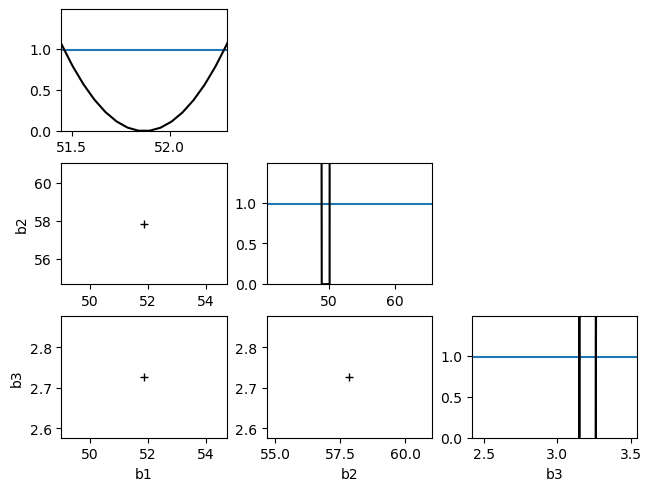

In [24]:
minuit.draw_mnmatrix();

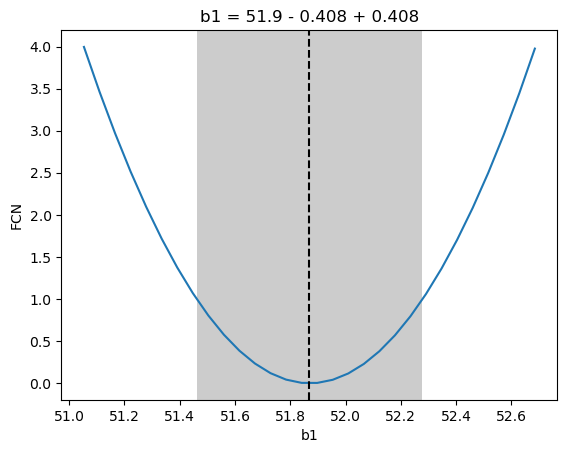

In [25]:
minuit.draw_mnprofile("b1");

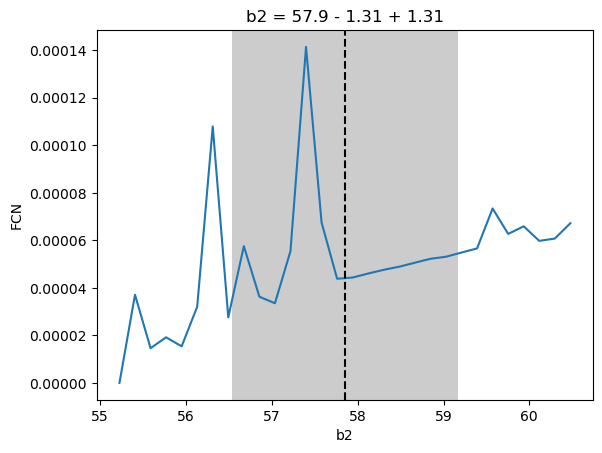

In [26]:
minuit.draw_mnprofile("b2");

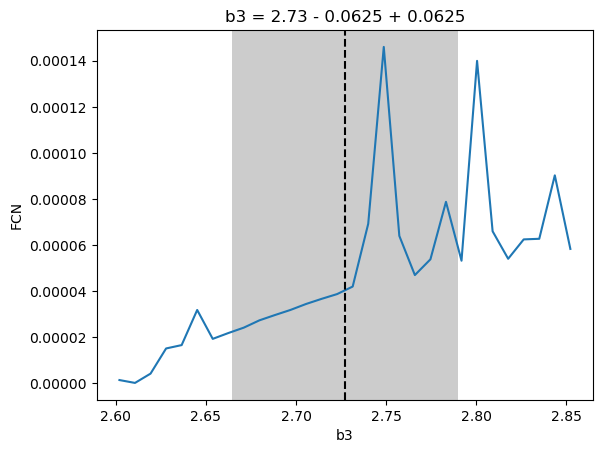

In [27]:
minuit.draw_mnprofile("b3");

So it looks that `iminuit` ran into similar problems as `scipy`. The starting parameters were so bad that the optimiser got stuck in a local minimum that is an artifact of numerical instabilities in the b2 and b3 parameters. The advantage of `iminuit` is that it has built-in likelihood profile plot, whereas with `scipy` you'd have to write a few lines of code yourself to compute and plot this.

## iminuit interactive fit

Another nice feature of `iminuit` is that it can be used interactively. You can run the fit in a loop and adjust the parameters by hand. This is useful to understand the model and data and to get a feeling for the parameter values.

Note that we create a new `Minuit` object here because `Minuit` is stateful and designed to be used interactively. So if we were to change it here, then the results and plots above would change if we rerun the cells. Creating Minuit objects is cheap, just create a new one for each fit you want to do.

In [28]:
minuit = iminuit.Minuit(cost, b1=1, b2=1, b3=1)
minuit.interactive()

After we play with the parameters to get in the right ballpark of the global optimum b1 = 72.462237576, b2 = 2.6180768402, b3 = 0.067359200066
then Minuit or any optimiser easily finds the optimum quickly.

This is what a good fit looks like - all green in the fit status, and likelihood profiles around the minimum are smooth and roughly parabolic:

In [29]:
minuit = iminuit.Minuit(cost, b1=100, b2=0, b3=0.05)
minuit.migrad()
minuit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.057 (χ²/ndof = 1.3)      │              Nfcn = 157              │
│ EDM = 3.87e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b1   │   72.5    │    1.5    │            │            │         │         │       │
│ 1 │ b2   │   2.62    │   0.08    │            │            │         │         │       │
│ 2 │ b3   │  0.0674   │  0.0029   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │        b1        b2        b3 │
├────┼───────────────────────────────┤
│ b1 │      2.12    -0.049 -3.510e-3 │
│ b2 │    -0.049   0.00578    181e-6 │
│ b3 │ -3.510e-3    181e-6  8.44e-06 │
└────┴───────────────────────────────┘

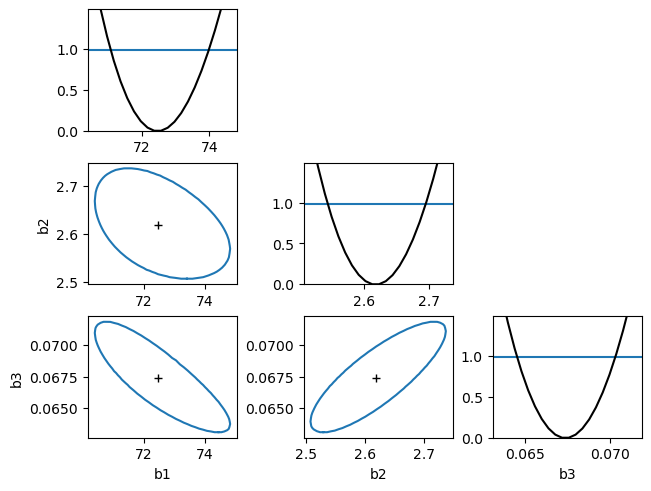

In [30]:
minuit.draw_mnmatrix();

## Summary and conclusions

I still have to finish writing this notebook. For now please also have a look at https://scikit-hep.org/iminuit at the tutorials in the documentation or if you like video tutials see [here](https://youtu.be/OtO9gkvHrAU?si=5Cn4nT1wgOsvyxTy).

We have seen some failing fits and now understand the typical problems. Lessons learned:

* Learning 1: if you get any warnings/errors, don't trust the fit. Fix them.
* Learning 2: scipy.optimize.curve_fit doesn't help you much to debug failing fits.
* Learning 3: Tracing the optimisation can sometimes give insights which parameters and model parts are the problem.
* Learning 4: A good way to check fit quality is to plot likelihood profiles for each parameter. (can be automated to compute metrics if it's roughly parabolic if you have many parameters or fits)
* Learning 5: In practice fixing failing fits usually means finding better initial guesses for the parameters or using bounds.
* Learning 6: Highly correlated or degnerate model parameters are bad. If possible try to avoid them by re-parametrising your model or fixing some parameters to average reasonable values.

Concerning the question if you should use `scipy.optimize` or `iminuit`:

* Learning 7: Both are great, and nowadays `scipy.optimize` has more robust optimizers and supports e.g. setting bounds.
* Learning 8: Some advantages of `iminuit` remain: (a) fix/free parametrs without touching model code, (b) better fit diagnostics and parameter error estimates, (c) easier to use interactively.




## Exercises

1. Choose one of the two bad models below (line/step) and your tool of choice (scipy/iminuit).
2. Try to fit the model to the data and observe how it fails and try to understand why.
3. Try to come up with a 3-parameter s-curve model that's easier to guess initial parameters and fit.

For (3) the [https://en.wikipedia.org/wiki/Logistic_function](logistic function) is a good starting point, and e.g. add a fourth parameter for a vertical shift but then fix the midpoint `x0` to the average of the data (or `x0=50`) you get a more "natural" parametrisation where you can guess the other parameters more easily from the data.

In [31]:
df

,x,y
0,9,8.93
1,14,10.80
2,21,18.59
3,28,22.33
4,42,39.35
5,57,56.11
6,63,61.73
7,70,64.62
8,79,67.08


In [32]:
def line_model(x, a, b, c):
    """A bad model with degeneracy in parameters a and b."""
    return a + b * x + c

In [33]:
def step_model(x, x_step, amplitude):
    """Another bad model with degeneracy in parameter x_step."""
    return np.where(x > x_step, amplitude, 0)

In [34]:
def rat42_model(x, b1, b2, b3):
    """The model we were using, good, but hard to guess b2 and b3."""
    return b1 / (1 + np.exp(b2 - b3 * x))